Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers than to attract new ones.

We need to predict whether the customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank. 

Build a model with the maximum possible *F1* score. To pass the project, you need an *F1* score of at least 0.59. Check the *F1* for the test set.

Additionally, measure the *AUC-ROC* metric and compare it with the *F1*.

Data source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# 1. Data preparation

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

df = pd.read_csv('./datasets/Churn.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [179]:
# convert some columns to bool types
df['Exited'] = df['Exited'].astype('bool')
df['HasCrCard'] = df['HasCrCard'].astype('bool')
df['IsActiveMember'] = df['IsActiveMember'].astype('bool')

# set index to CustomerId
df.set_index('CustomerId', inplace=True)

# convert Gender column to isMale column with bool type
df['isMale'] = df['Gender'] == 'Male'

# remove RowNumber and Surname as these are not relevant for model training
df.drop(['RowNumber', 'Surname', 'Gender'], axis=1, inplace=True)

# -1 Tenure will indicate the abscence of fixed deposit
df['Tenure'].fillna(-1, inplace=True)

df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

In [180]:
df.info()
df.sample(5, random_state=42)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  bool   
 6   IsActiveMember     10000 non-null  bool   
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  bool   
 9   isMale             10000 non-null  bool   
 10  Geography_Germany  10000 non-null  uint8  
 11  Geography_Spain    10000 non-null  uint8  
dtypes: bool(4), float64(3), int64(3), uint8(2)
memory usage: 605.5 KB


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,isMale,Geography_Germany,Geography_Spain
CustomerId,,,,,,,,,,,,
15687492,596,32,3.0,96709.07,2,False,False,41788.37,False,True,1,0
15736963,623,43,1.0,0.00,2,True,True,146379.30,False,True,0,0
15721730,601,44,4.0,0.00,2,True,False,58561.31,False,False,0,1
15762134,506,59,8.0,119152.10,2,True,True,170679.74,False,True,1,0
15648898,560,27,7.0,124995.98,1,True,True,114669.79,False,False,0,1


## We've successfully prepared the data.

We've converted all the columns that could be converted to a bool type (Exited, HasCrCard, IsActiveMember, Gender). 

We've used OHE for Geography column so we can train a better a model with this categorical variable

We've removed columns which should not affect resulting model at all and might actually prevent us from training a good model.

We've left CredistScore, Age, Tenure, Balance, NumOfProducts and EstimatedSalary unchanged.

We have data for all of the rows. The only Null values we have a for Tenure column. But it is right - Null Tenure means that customer doesn't have a fixed deposit for maturation. However NaN values might get in a way when we train our model. So we've replaced them with -1

# 2. Task research

In [181]:
target = df['Exited']
features = df.drop('Exited', axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

model = RandomForestClassifier(random_state=12345)
model.fit(features_train, target_train)

predictions_valid = model.predict(features_valid)
print('Accuracy for a pilot model', accuracy_score(target_valid, predictions_valid))
print('confusion matrix\n', confusion_matrix(target_valid, predictions_valid), sep='')
print('f1_score', f1_score(target_valid, predictions_valid))

Accuracy for a pilot model 0.8552
confusion matrix
[[1896   69]
 [ 293  242]]
f1_score 0.5721040189125296


Let's do a sanity check for our base model

In [182]:
target_pred_constant = pd.Series(False, index=target_valid.index)
print('Accuracy for a constant model', accuracy_score(target_valid, target_pred_constant))
print('confusion matrix\n', confusion_matrix(target_valid, target_pred_constant), sep='')
print('f1_score', f1_score(target_valid, target_pred_constant))

Accuracy for a constant model 0.786
confusion matrix
[[1965    0]
 [ 535    0]]
f1_score 0.0


Our base model has a pretty good accuracy and even passes a sanity check. However it's F1 score is lower than our target

# 3. Fixing class imbalance

In [183]:
target_train.value_counts()

False    5998
True     1502
Name: Exited, dtype: int64

There is a slight class imbalance in our dataset. We can use upsampling to make it more balanced

In [184]:
features_train_true = features_train[target_train == True]
features_train_false = features_train[target_train == False]
target_train_true = target_train[target_train == True]
target_train_false = target_train[target_train == False]

features_upsampled = pd.concat([features_train_false] + [features_train_true] * 3)
target_upsampled = pd.concat([target_train_false] + [target_train_true] * 3)

features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

target_upsampled.value_counts()

False    5998
True     4506
Name: Exited, dtype: int64

In [185]:
target_f1 = 0.59
best_est = 0
best_depth = 0
best_threshold = 0
best_f1 = 0

for est in range(10, 100, 20):
    for depth in range(4, 10, 2):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_upsampled, target_upsampled)

        predictions_valid = model.predict(features_valid)

        for threshold in np.arange(0.35, 0.65, 0.02):
            probs = model.predict_proba(features_valid)
            predicted_valid = probs[:, 1] > threshold
            f1 = f1_score(target_valid, predicted_valid)
            accuracy = accuracy_score(target_valid, predicted_valid)

            if (f1 > target_f1 and f1 > best_f1):
                best_est, best_depth, best_threshold, best_f1 = est, depth, threshold, f1

                print(
                    'Threshold = {:.2f} | F1_score = {:.3f}, Accuracy = {:.4f}, Estimators = {:.0f}, Depth = {:.0f}'.format(
                        threshold, f1, accuracy, est, depth
                    )
                )

Threshold = 0.45 | F1_score = 0.593, Accuracy = 0.7628, Estimators = 10, Depth = 4
Threshold = 0.47 | F1_score = 0.595, Accuracy = 0.7756, Estimators = 10, Depth = 4
Threshold = 0.49 | F1_score = 0.608, Accuracy = 0.7912, Estimators = 10, Depth = 4
Threshold = 0.51 | F1_score = 0.628, Accuracy = 0.8136, Estimators = 10, Depth = 4
Threshold = 0.57 | F1_score = 0.635, Accuracy = 0.8508, Estimators = 10, Depth = 4
Threshold = 0.55 | F1_score = 0.636, Accuracy = 0.8372, Estimators = 10, Depth = 8
Threshold = 0.57 | F1_score = 0.639, Accuracy = 0.8448, Estimators = 10, Depth = 8
Threshold = 0.51 | F1_score = 0.643, Accuracy = 0.8256, Estimators = 30, Depth = 8
Threshold = 0.53 | F1_score = 0.643, Accuracy = 0.8324, Estimators = 30, Depth = 8
Threshold = 0.53 | F1_score = 0.649, Accuracy = 0.8360, Estimators = 50, Depth = 8
Threshold = 0.53 | F1_score = 0.650, Accuracy = 0.8360, Estimators = 70, Depth = 8
Threshold = 0.53 | F1_score = 0.650, Accuracy = 0.8372, Estimators = 90, Depth = 8


We've fixed class imbalance by upsampling cases where clients left the bank. We've also used balanced class weights and threshold adjustment to find the best model that fits our requirements of F1_score >= 0.59.

# 4. Model testing

In [191]:
best_model = RandomForestClassifier(n_estimators=best_est, max_depth=best_depth, random_state=12345, class_weight='balanced')
best_model.fit(features_upsampled, target_upsampled)

probs = best_model.predict_proba(features_valid)
predicted_valid = probs[:, 1] > best_threshold

print('Best model accuracy = {:.4f}'.format(accuracy_score(target_valid, predicted_valid)))
print('Best model f1_score = {:.4f}'.format(f1_score(target_valid, predicted_valid)))
print('ROC AUC score = {:.4f}'.format(roc_auc_score(target_valid, probs[:, 1])))
print('confusion matrix\n', confusion_matrix(target_valid, predicted_valid), sep='')

Best model accuracy = 0.8372
Best model f1_score = 0.6500
ROC AUC score = 0.8641
confusion matrix
[[1715  250]
 [ 157  378]]


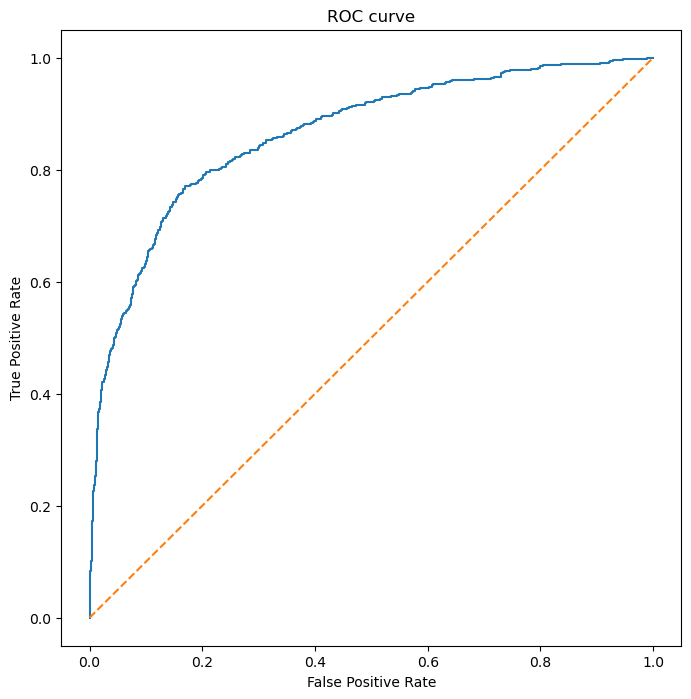

In [192]:
tpr, fpr, threshold = roc_curve(target_valid, probs[:, 1])

plt.figure(figsize=(8, 8))
plt.plot(tpr, fpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


# Conclusion 
We've trained a pretty good model that surpasses the requirements. If we look at the confusion matrix we can see that our models weakest spot is determining a false positive result. We might predict that more customers will leave the bank than they actually will - may be it's not that bad as it will help us be more alert and care more about the customers.

We've also built ROC curve and saw that it has a lot of space under the curve which means that our model is pretty good at distinguishing between true and false positives